# CS6650 Homework 1
V S S Anirudh Sharma
EE18B036

## Install Libraries

In [1]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\vanir\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


## Importing Libraries

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_prominences, butter, sosfilt
from scipy import fft
from tabulate import tabulate

##  Functions

In [3]:
def cleanSignal(x,w = 7):
    return np.convolve((x-np.mean(x)), np.ones(w), 'valid')/w

In [15]:
def rescale_frame(frame, percent=100):
    width = int(frame.shape[1] * percent/ 100)
    height = int(frame.shape[0] * percent/ 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation =cv2.INTER_AREA)

### Helping in Time series technique

In [4]:
#return number of peaks in cleaned green per given time
def peakFreq(green, fps_act = 30, w=7):
    l = len(green)
    signal = cleanSignal(green,w)
    peaks, _ = find_peaks(signal,distance = 5)
    BPM_calc = 60*len(peaks)*fps_act/l
    return BPM_calc

### Helping in DFT technique

In [5]:
# returns DFT of a given vector after cleaning it
def dft_util(green, w=7):   
    signal = cleanSignal(green,w)
    # compute DFT with optimized FFT
    fs = np.fft.fftfreq(signal.shape[0])
    sp = np.fft.fft(signal)
    freq = np.fft.fftfreq(signal.shape[-1])
    wh = np.where(freq>0)
    return freq[wh],abs(sp)[wh]

In [6]:
#return highest peak in the dft of a signal in range of 40BPM-200BPM
def majorFreq(green,fps_act = 30,w1 = 7,w2=2, minPulse = 40, maxPulse = 200):    
    W,Y = dft_util(green,w1)
    cleaned = cleanSignal(Y,w2); W1 = W[w2-1:]
    minFreq = minPulse/(60*fps_act)
    maxFreq = maxPulse/(60*fps_act)
    normal = np.where(np.logical_and(W1>minFreq , W1<maxFreq))
    cleaned2 = cleaned[normal]
    W2 = W1[normal]
    peaksFreq, _ = find_peaks(cleaned2,distance = 5)
    try:
        BPM_calc = W2[max(peaksFreq, key=lambda p: cleaned2[p])]*60*fps_act
    except:
        
        return 0
    return BPM_calc

In [7]:
#Computing pulse form a full video using DFT technique
def BPM_dft(videoName,w1 = 7, w2 = 2):
    green =  []
    cap = cv2.VideoCapture(videoName)

    # Read until video is completed
    while(cap.isOpened()):
      # Capture frame-by-frame
      ret, frame = cap.read()
      if ret == True:
        #b = frame[:, :, :1]
        g = frame[:, :, 1:2]
        #r = frame[:, :, 2:]

        # computing the mean
        #b_mean = np.mean(b)
        g_mean = np.mean(g)
        #r_mean = np.mean(r)
        green.append(g_mean)  

      # Break the loop
      else: 
        break  

    # When everything done,find fps of video and release the video capture object
    fps_act = cap.get(cv2.CAP_PROP_FPS)
    cap.release()
    #print(len(green))
    '''
    W,Y = func1(green,w1)
    cleaned = cleanSignal(Y,w2); W1 = W[w2-1:]
    peaksFreq, _ = find_peaks(cleaned,distance = 5)
    BPM_calc = W1[max(peaksFreq, key=lambda p: cleaned[p])]*60*fps_act
    '''
    return majorFreq(green,fps_act,w1,w2)
    
    
    #return BPM_calc

In [8]:
#Computing pulse form a full video using Time series technique
def BPM_ts(videoName,w = 7):
    green =  []
    cap = cv2.VideoCapture(videoName)

    # Read until video is completed
    while(cap.isOpened()):
      # Capture frame-by-frame
      ret, frame = cap.read()
      if ret == True:
        b = frame[:, :, :1]
        g = frame[:, :, 1:2]
        r = frame[:, :, 2:]

        # computing the mean
        #b_mean = np.mean(b)
        g_mean = np.mean(g)
        #r_mean = np.mean(r)
        green.append(g_mean)  

      # Break the loop
      else: 
        break  

    # When everything done,find fps of video and release the video capture object
    fps_act = cap.get(cv2.CAP_PROP_FPS)
    cap.release()
    
    return peakFreq(green, fps_act,w)

# Q2

In [9]:
def plot_5sec(videoName):
    green =  np.zeros((0,1))
    cap = cv2.VideoCapture(videoName)
    fps_act = cap.get(cv2.CAP_PROP_FPS)
    N = int(fps_act*5)
    # Read until video is completed
    i = 0
    while(cap.isOpened() and i<N):
       
      # Capture frame-by-frame
      ret, frame = cap.read()
      if ret == True:
        b = frame[:, :, :1]
        g = frame[:, :, 1:2]
        r = frame[:, :, 2:]

        # computing the mean
        #b_mean = np.mean(b)
        g_mean = np.mean(g)
        #r_mean = np.mean(r)
        green = np.append(green,[g_mean])  
        i += 1 

      # Break the loop
      else: 
        break  
    
    # When everything done,find fps of video and release the video capture object
    
    cap.release()
    l = green.shape[0]
    return [i/fps_act for i in range(l)], green - np.mean(green)

In [10]:
t1, s1 = plot_5sec('EE18B036_1.mp4')
t2, s2 = plot_5sec('EE18B036_2.mp4')
t3, s3 = plot_5sec('EE18B036_3.mp4')

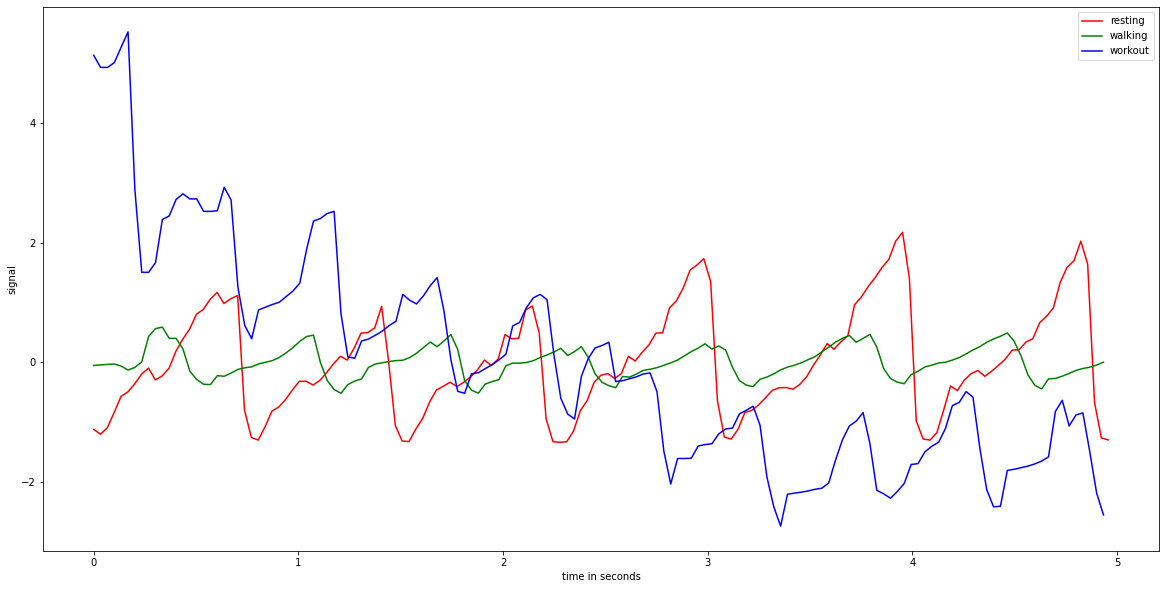

In [11]:
w = 7
plt.figure(figsize = (20,10))
plt.plot(t1,s1,'r',label = 'resting')#,linewidth = 0.5)
#plt.plot(t1[:-w+1],cleanSignal(s1,w),'r',label = 'cleaned resting')
plt.plot(t2,s2,'g',label = 'walking')#,linewidth = 0.5)
#plt.plot(t2[:-w+1],cleanSignal(s2,w),'g',label = 'cleaned waling')
plt.plot(t3,s3,'b',label = 'workout')#,linewidth = 0.5)
#plt.plot(t3[:-w+1],cleanSignal(s3,w),'b',label = 'cleaned workout')
plt.xlabel('time in seconds')
plt.ylabel('signal')
plt.legend()
plt.show()

In [12]:
#Return pulse rate for the first t seconds of video using time series technique
def BPM_sec_ts(videoName,t = 5,rescale = 100,fpsScale = 1, w = 7):
    green = []
    cap = cv2.VideoCapture(videoName)
    #fps = cap.get(cv2.CAP_PROP_FPS)
    #cap.set(cv2.CAP_PROP_FPS, fps*fpsScale/100) 
    fps = cap.get(cv2.CAP_PROP_FPS)
    #print(fps)
    bpm = 0
    #fps = cap.get(cv2.CAP_PROP_FPS)
    N = int(t*fps)
    #result = cv2.VideoWriter('2_bpm.mp4', cv2.VideoWriter_fourcc(*'MP4V'),fps,(1920,1080))
    # Read until video is completed
    i = 0
    font = cv2.FONT_HERSHEY_SIMPLEX
    while(cap.isOpened() and i<N):
      # Capture frame-by-frame
      ret, frame = cap.read()

      if ret == True:
        i += 1
        # Display the resulting frame
        # setting values for base colors
        
        if i%fpsScale == 0:
            frame2 = rescale_frame(frame, rescale)
            g = frame2[:, :, 1]

            # computing the mean
            g_mean = np.mean(g)
            green.append(g_mean)
        


        # Press Q on keyboard to  exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
          break



      # Break the loop
      else: 
        break  

    # When everything done, release the video capture object
    cap.release()
    #result.release()

    return peakFreq(green, fps/fpsScale)

In [13]:
#Return pulse rate for the first t seconds of video using time series technique
def BPM_sec_dft(videoName, t, rescale = 100,fpsScale = 1, w1 = 7,w2=2):
    green = []
    cap = cv2.VideoCapture(videoName)
    bpm = 0
    fps = cap.get(cv2.CAP_PROP_FPS)
    N = int(t*fps)
    #result = cv2.VideoWriter('2_bpm.mp4', cv2.VideoWriter_fourcc(*'MP4V'),fps,(1920,1080))
    # Read until video is completed
    i = 0
    font = cv2.FONT_HERSHEY_SIMPLEX
    while(cap.isOpened() and i<N):
      # Capture frame-by-frame
      ret, frame = cap.read()

      if ret == True:
        i += 1
        # Display the resulting frame
        # setting values for base colors
        if i%fpsScale == 0:
            frame2 = rescale_frame(frame, rescale)
            g = frame2[:, :, 1]

            # computing the mean
            g_mean = np.mean(g)
            green.append(g_mean)



        # Press Q on keyboard to  exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
          break



      # Break the loop
      else: 
        break  

    # When everything done, release the video capture object
    cap.release()
    #result.release()

    return majorFreq(green,fps/fpsScale,w1,w2)

In [16]:
TS_5_1 = BPM_sec_ts('EE18B036_1.mp4',5)
TS_5_2 = BPM_sec_ts('EE18B036_2.mp4',5)
TS_5_3 = BPM_sec_ts('EE18B036_3.mp4',5)

DFT_5_1 = BPM_sec_dft('EE18B036_1.mp4',5)
DFT_5_2 = BPM_sec_dft('EE18B036_2.mp4',5)
DFT_5_3 = BPM_sec_dft('EE18B036_3.mp4',5)


In [17]:
# assign data
fiveSecData = [["Time Series", TS_5_1, TS_5_2, TS_5_3], ["DFT", DFT_5_1, DFT_5_2, DFT_5_3]]
  
# create header
head = ["Method", "Resting", "Walking", "Workout"]
  
# display table
print('in the first 5 seconds:')
print(tabulate(fiveSecData, headers=head, tablefmt="grid"))

in the first 5 seconds:
+-------------+-----------+-----------+-----------+
| Method      |   Resting |   Walking |   Workout |
+=============+===========+===========+===========+
| Time Series |   72.135  |   84.5512 |   108.704 |
+-------------+-----------+-----------+-----------+
| DFT         |   75.1616 |   88.1238 |   125.886 |
+-------------+-----------+-----------+-----------+


In [18]:
TS_10_1 = BPM_sec_ts('EE18B036_1.mp4',10)
TS_10_2 = BPM_sec_ts('EE18B036_2.mp4',10)
TS_10_3 = BPM_sec_ts('EE18B036_3.mp4',10)


DFT_10_1 = BPM_sec_dft('EE18B036_1.mp4',10)
DFT_10_2 = BPM_sec_dft('EE18B036_2.mp4',10)
DFT_10_3 = BPM_sec_dft('EE18B036_3.mp4',10)


In [19]:
# assign data
tenSecData = [["Time Series", TS_10_1, TS_10_2, TS_10_3], ["DFT", DFT_10_1, DFT_10_2, DFT_10_3]]
  
# create header
head = ["Method", "Resting", "Walking", "Workout"]
  
# display table
print('in the first 10 seconds:')
print(tabulate(tenSecData, headers=head, tablefmt="grid"))

in the first 10 seconds:
+-------------+-----------+-----------+-----------+
| Method      |   Resting |   Walking |   Workout |
+=============+===========+===========+===========+
| Time Series |   66.1237 |   84.2665 |   108.338 |
+-------------+-----------+-----------+-----------+
| DFT         |   73.6172 |   98.2903 |   116.715 |
+-------------+-----------+-----------+-----------+


In [20]:
TS_20_1 = BPM_sec_ts('EE18B036_1.mp4',20)
TS_20_2 = BPM_sec_ts('EE18B036_2.mp4',20)
TS_20_3 = BPM_sec_ts('EE18B036_3.mp4',20)


DFT_20_1 = BPM_sec_dft('EE18B036_1.mp4',20)
DFT_20_2 = BPM_sec_dft('EE18B036_2.mp4',20)
DFT_20_3 = BPM_sec_dft('EE18B036_3.mp4',20)


In [21]:
# assign data
twentySecData = [["Time Series", TS_20_1, TS_20_2, TS_20_3], ["DFT", DFT_20_1, DFT_20_2, DFT_20_3]]
  
# create header
head = ["Method", "Resting", "Walking", "Workout"]
  
# display table
print('in the first 20 seconds:')
print(tabulate(twentySecData, headers=head, tablefmt="grid"))

in the first 20 seconds:
+-------------+-----------+-----------+-----------+
| Method      |   Resting |   Walking |   Workout |
+=============+===========+===========+===========+
| Time Series |   72.0141 |   81.1204 |   108.156 |
+-------------+-----------+-----------+-----------+
| DFT         |   72.7453 |   81.9468 |   109.258 |
+-------------+-----------+-----------+-----------+


In [22]:
BPMdata = [[5, TS_5_1, TS_5_2, TS_5_3, DFT_5_1, DFT_5_2, DFT_5_3], [10, TS_10_1, TS_10_2, TS_10_3, DFT_10_1, DFT_10_2, DFT_10_3], [20, TS_20_1, TS_20_2, TS_20_3,  DFT_20_1, DFT_20_2, DFT_20_3] ]

In [23]:
BPMhead = ["Time in sec", "TS Resting", "TS Walking", "TS Workout", "DFT Resting", "DFT Walking", "DFT Workout"]

In [24]:
print('Estimates of pulse rate over different periods of time by different algorithm')
print(tabulate(BPMdata, headers=BPMhead, tablefmt="grid"))

Estimates of pulse rate over different periods of time by different algorithm
+---------------+--------------+--------------+--------------+---------------+---------------+---------------+
|   Time in sec |   TS Resting |   TS Walking |   TS Workout |   DFT Resting |   DFT Walking |   DFT Workout |
+===============+==============+==============+==============+===============+===============+===============+
|             5 |      72.135  |      84.5512 |      108.704 |       75.1616 |       88.1238 |       125.886 |
+---------------+--------------+--------------+--------------+---------------+---------------+---------------+
|            10 |      66.1237 |      84.2665 |      108.338 |       73.6172 |       98.2903 |       116.715 |
+---------------+--------------+--------------+--------------+---------------+---------------+---------------+
|            20 |      72.0141 |      81.1204 |      108.156 |       72.7453 |       81.9468 |       109.258 |
+---------------+--------------+--

# Q3
Playing video with pulse rate being displayed on it

In [25]:
#display video with pulse rate every second taken over 5 seconds using time series technique
def BPM_disp_ts(videoName,w = 7):
    green = []
    cap = cv2.VideoCapture(videoName)
    bpm = 0
    fps = cap.get(cv2.CAP_PROP_FPS)
    N = int(5*fps)
    #result = cv2.VideoWriter('2_bpm.mp4', cv2.VideoWriter_fourcc(*'MP4V'),fps,(1920,1080))
    # Read until video is completed
    i = 0
    font = cv2.FONT_HERSHEY_SIMPLEX
    while(cap.isOpened()):
      # Capture frame-by-frame
      ret, frame = cap.read()

      if ret == True:
        i += 1
        # Display the resulting frame
        # setting values for base colors

        g = frame[:, :, 1:2]

        # computing the mean
        g_mean = np.mean(g)
        green.append(g_mean)

        if i>N and i%(N//5)==0:
            
            bpm = peakFreq(green[-N:], fps, w)


        cv2.putText(frame, 
                    '{}:PulseRate = {} BPM'.format(videoName,bpm), 
                    (50, 50), 
                    font, 1, 
                    (0, 255, 255), 
                    2, 
                    cv2.LINE_4)
        cv2.imshow('Frame',frame)

        #result.write(frame)    



        # Press Q on keyboard to  exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
          break



      # Break the loop
      else: 
        break  

    # When everything done, release the video capture object
    cap.release()
    #result.release()

    # Closes all the frames
    cv2.destroyAllWindows()

In [26]:
#display video with pulse rate every second taken over 5 seconds using DFT technique
def BPM_disp_dft(videoName,w1 = 7,w2 = 2):
    green = []
    cap = cv2.VideoCapture(videoName)
    bpm = 0
    fps = cap.get(cv2.CAP_PROP_FPS)
    N = int(5*fps)
    #result = cv2.VideoWriter('2_bpm.mp4', cv2.VideoWriter_fourcc(*'MP4V'),fps,(1920,1080))
    # Read until video is completed
    i = 0
    font = cv2.FONT_HERSHEY_SIMPLEX
    while(cap.isOpened()):
      # Capture frame-by-frame
      ret, frame = cap.read()

      if ret == True:
        i += 1
        # Display the resulting frame
        # setting values for base colors

        g = frame[:, :, 1:2]

        # computing the mean
        g_mean = np.mean(g)
        green.append(g_mean)

        if i>N and i%(N//5)==0:
            
            bpm = majorFreq(green[-N:],fps,w1,w2)

        cv2.putText(frame, 
                    '{}:PulseRate = {} BPM'.format(videoName,bpm), 
                    (50, 50), 
                    font, 1, 
                    (0, 255, 255), 
                    2, 
                    cv2.LINE_4)
        cv2.imshow('Frame',frame)

        #result.write(frame)    



        # Press Q on keyboard to  exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
          break



      # Break the loop
      else: 
        break  

    # When everything done, release the video capture object
    cap.release()
    #result.release()

    # Closes all the frames
    cv2.destroyAllWindows()

In [27]:
#from Time Series Method
BPM_disp_ts('EE18B036_1.mp4')
BPM_disp_ts('EE18B036_2.mp4')
BPM_disp_ts('EE18B036_3.mp4')

In [28]:
#from DFT Method
BPM_disp_dft('EE18B036_1.mp4')
BPM_disp_dft('EE18B036_2.mp4')
BPM_disp_dft('EE18B036_3.mp4')

# Q4

In [29]:
#Return pulse rate for the first 5 seconds of video using time series technique
def BPM_5sec_ts(videoName,rescale = 100,fpsScale = 1, w = 7):
    green = []
    cap = cv2.VideoCapture(videoName) 
    fps = cap.get(cv2.CAP_PROP_FPS)
    bpm = 0
    N = int(5*fps) #5 seconds
    #result = cv2.VideoWriter('2_bpm.mp4', cv2.VideoWriter_fourcc(*'MP4V'),fps,(1920,1080))
    # Read until video is completed
    i = 0
    while(cap.isOpened() and i<N):
      # Capture frame-by-frame
      ret, frame = cap.read()

      if ret == True:
        i += 1
        # Display the resulting frame
        # setting values for base colors
        
        if i%fpsScale == 0:
            frame2 = rescale_frame(frame, rescale)
            g = frame2[:, :, 1]

            # computing the mean
            g_mean = np.mean(g)
            green.append(g_mean)
        


        # Press Q on keyboard to  exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
          break



      # Break the loop
      else: 
        break  

    # When everything done, release the video capture object
    cap.release()
    #result.release()

    return peakFreq(green, fps/fpsScale)

In [30]:
#Return pulse rate for the first 5 seconds of video using DFT technique
def BPM_5sec_dft(videoName,rescale = 100,fpsScale = 1, w1 = 7,w2=2):
    green = []
    cap = cv2.VideoCapture(videoName)
    bpm = 0
    fps = cap.get(cv2.CAP_PROP_FPS)
    N = int(5*fps)
    #result = cv2.VideoWriter('2_bpm.mp4', cv2.VideoWriter_fourcc(*'MP4V'),fps,(1920,1080))
    # Read until video is completed
    i = 0
    font = cv2.FONT_HERSHEY_SIMPLEX
    while(cap.isOpened() and i<N):
      # Capture frame-by-frame
      ret, frame = cap.read()

      if ret == True:
        i += 1
        # Display the resulting frame
        # setting values for base colors
        if i%fpsScale == 0:
            frame2 = rescale_frame(frame, rescale)
            g = frame2[:, :, 1]

            # computing the mean
            g_mean = np.mean(g)
            green.append(g_mean)



        # Press Q on keyboard to  exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
          break



      # Break the loop
      else: 
        break  

    # When everything done, release the video capture object
    cap.release()
    #result.release()

    return majorFreq(green,fps/fpsScale,w1,w2)

In [31]:
frameScales = [i for i in range(20,101,20)]

In [32]:
fpsScales = [i for i in range(1,10)]

In [33]:
frameRates = [30/i for i in fpsScales]

In [34]:
## TIME SERIES

In [35]:
BPM1_frsc_ts = [BPM_5sec_ts('EE18B036_1.mp4',i,1) for i in frameScales]

In [36]:
BPM2_frsc_ts = [BPM_5sec_ts('EE18B036_2.mp4',i,1) for i in frameScales]

In [37]:
BPM3_frsc_ts = [BPM_5sec_ts('EE18B036_3.mp4',i,1) for i in frameScales]

In [38]:
BPM1_fpssc_ts = [BPM_5sec_ts('EE18B036_1.mp4',100,i) for i in fpsScales]

In [39]:
BPM2_fpssc_ts = [BPM_5sec_ts('EE18B036_2.mp4',100,i) for i in fpsScales]

In [40]:
BPM3_fpssc_ts = [BPM_5sec_ts('EE18B036_3.mp4',100,i) for i in fpsScales]

In [41]:
# DFT

In [42]:
BPM1_frsc_dft = [BPM_5sec_dft('EE18B036_1.mp4',i,1) for i in frameScales]

In [43]:
BPM2_frsc_dft = [BPM_5sec_dft('EE18B036_2.mp4',i,1) for i in frameScales]

In [44]:
BPM3_frsc_dft = [BPM_5sec_dft('EE18B036_3.mp4',i,1) for i in frameScales]

In [45]:
BPM1_fpssc_dft = [BPM_5sec_dft('EE18B036_1.mp4',100,i) for i in fpsScales]

In [46]:
BPM2_fpssc_dft = [BPM_5sec_dft('EE18B036_2.mp4',100,i) for i in fpsScales]

In [47]:
BPM3_fpssc_dft = [BPM_5sec_dft('EE18B036_3.mp4',100,i) for i in fpsScales]

In [48]:
#plots

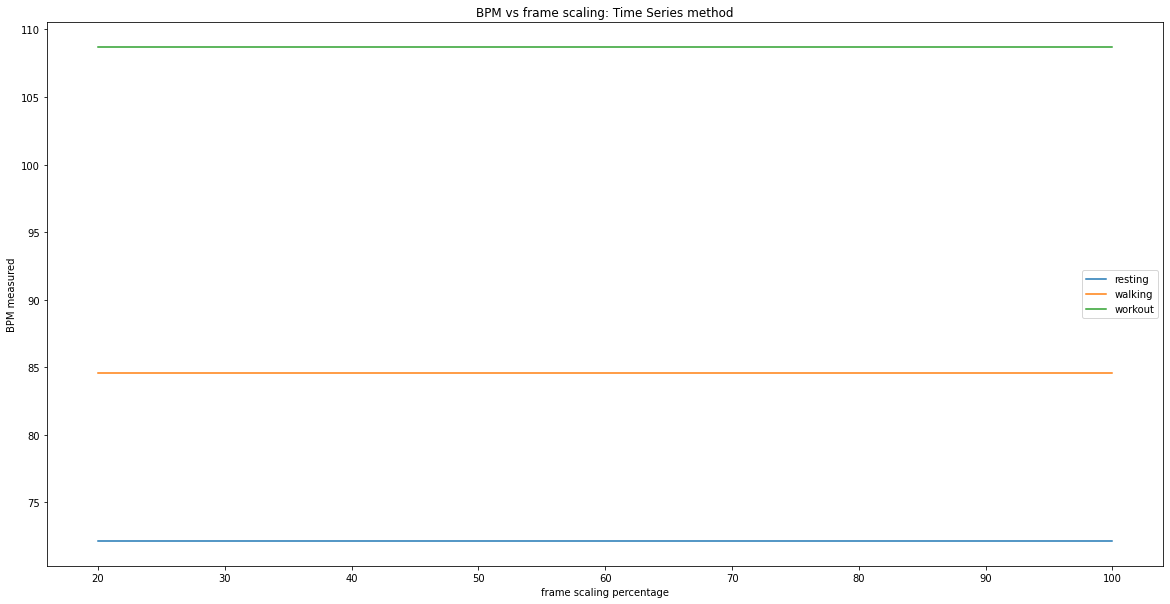

In [49]:
plt.figure(figsize = (20,10))
plt.plot(frameScales,BPM1_frsc_ts,label = 'resting')
plt.plot(frameScales,BPM2_frsc_ts,label = 'walking')
plt.plot(frameScales,BPM3_frsc_ts,label = 'workout')
plt.xlabel('frame scaling percentage')
plt.ylabel('BPM measured')
plt.title('BPM vs frame scaling: Time Series method')
plt.legend()

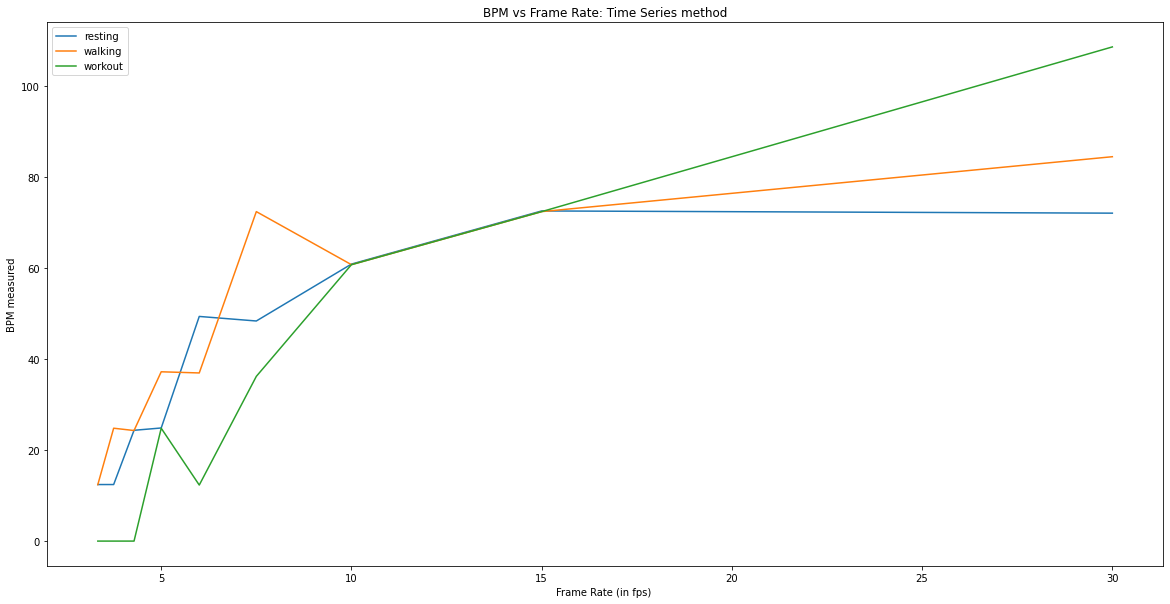

In [50]:
plt.figure(figsize = (20,10))
plt.plot(frameRates,BPM1_fpssc_ts,label = 'resting')
plt.plot(frameRates,BPM2_fpssc_ts,label = 'walking')
plt.plot(frameRates,BPM3_fpssc_ts,label = 'workout')
plt.xlabel('Frame Rate (in fps) ')
plt.ylabel('BPM measured')
plt.title('BPM vs Frame Rate: Time Series method')
plt.legend()

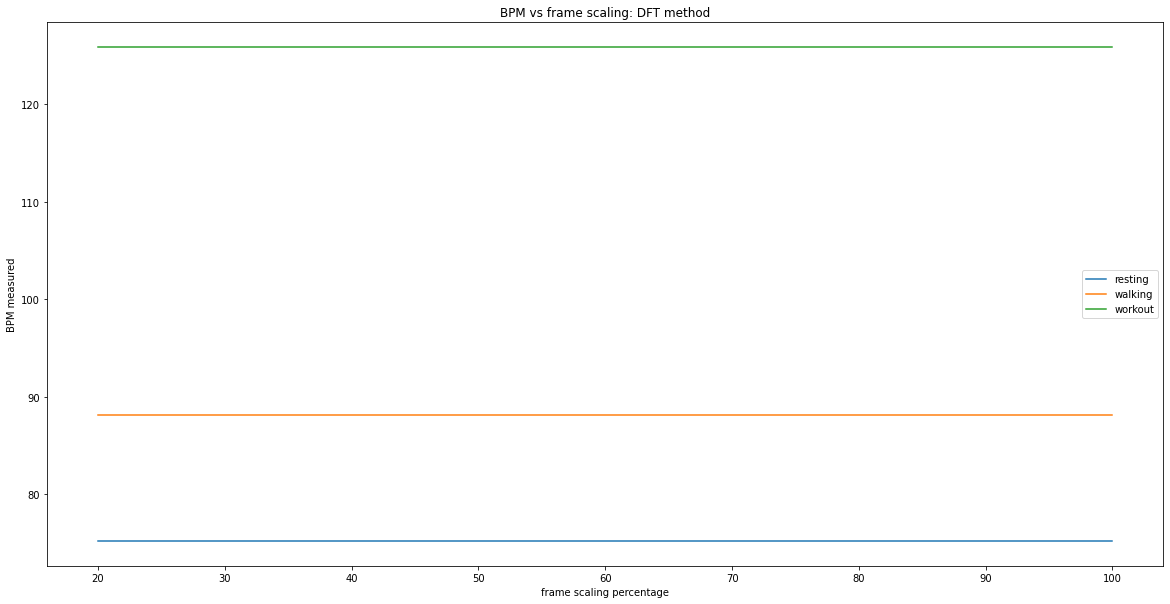

In [51]:
plt.figure(figsize = (20,10))
plt.plot(frameScales,BPM1_frsc_dft,label = 'resting')
plt.plot(frameScales,BPM2_frsc_dft,label = 'walking')
plt.plot(frameScales,BPM3_frsc_dft,label = 'workout')
plt.xlabel('frame scaling percentage')
plt.ylabel('BPM measured')
plt.title('BPM vs frame scaling: DFT method')
plt.legend()

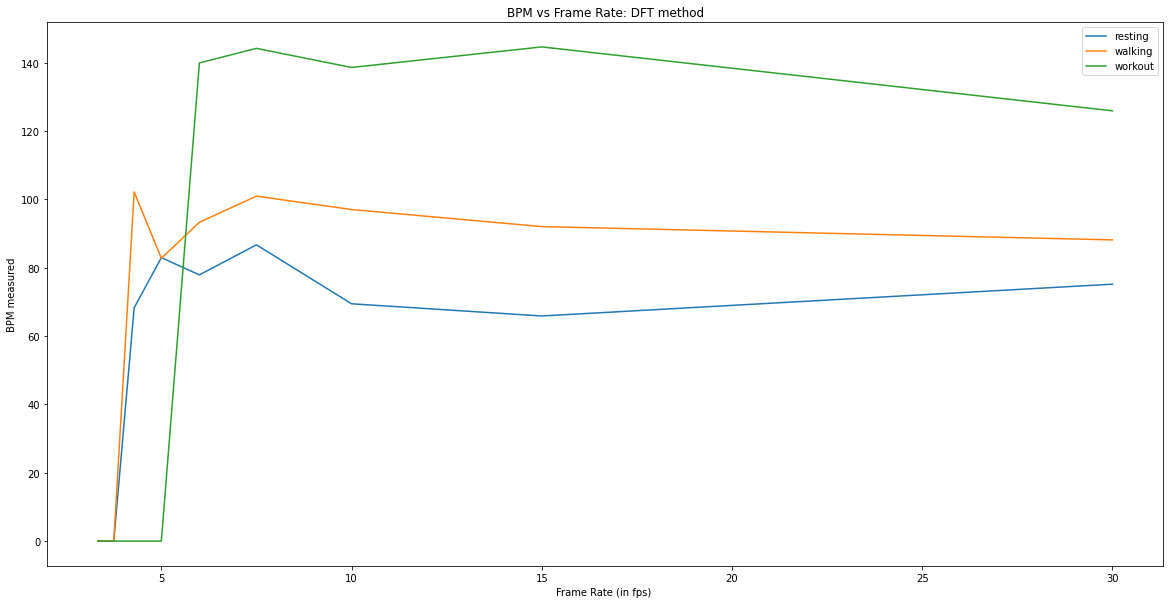

In [52]:
plt.figure(figsize = (20,10))
plt.plot(frameRates,BPM1_fpssc_dft,label = 'resting')
plt.plot(frameRates,BPM2_fpssc_dft,label = 'walking')
plt.plot(frameRates,BPM3_fpssc_dft,label = 'workout')
plt.xlabel('Frame Rate (in fps) ')
plt.ylabel('BPM measured')
plt.title('BPM vs Frame Rate: DFT method')
plt.legend()

## Finding only dynamic pixels in the frame to enhance SNR

In [53]:
def dynamicOnly(frame1, frame2,cutoff = 5):
    f = abs(frame1 - frame2)
    gmax = np.max((f[:,:,1]))
    select = np.where(abs(f[:,:,1])>=gmax*cutoff/100)
    return select

In [54]:
#Return pulse rate for the first t seconds of video using time series technique and using dynamic pixels only
def BPM_better_ts(videoName,t = 5, cutoff = 10,w0 = 7, w1 = 7):
    green = []
    cap = cv2.VideoCapture(videoName)
    bpm = 0
    fps = cap.get(cv2.CAP_PROP_FPS)
    N = int(fps)
    #result = cv2.VideoWriter('2_bpm.mp4', cv2.VideoWriter_fourcc(*'MP4V'),fps,(1920,1080))
    # Read until video is completed
    i = 0
    #print(cap.get(3))
    prevFrame = np.zeros((int(cap.get(4)),int(cap.get(3)),3))
    #print(prevFrame.shape)
    font = cv2.FONT_HERSHEY_SIMPLEX
    while(cap.isOpened() and i<t*N):
      # Capture frame-by-frame
      ret, frame = cap.read()
      #print(frame.dtype, frame.shape)
      if ret == True:
        i += 1


        if i< N:
            g = frame[:, :, 1]

            # computing the mean

        else:
            if i%N == 0:
                select = dynamicOnly(prevFrame, frame,cutoff)
                
            g = frame[:,:,1][select]
                #print(g.shape)



        g_mean = np.mean(g)
        green.append(g_mean)
        prevFrame = frame 
   

      # Break the loop
      else: 
        break  

    # When everything done, release the video capture object
    cap.release()
    
    return peakFreq(cleanSignal(green,w0), fps,w1)

In [55]:
#Return pulse rate for the first t seconds of video using time series technique and using dynamic pixels only
def BPM_better_dft(videoName,t = 5, cutoff = 20,w0 = 10, w1 = 7, w2 = 2):
    green = []
    cap = cv2.VideoCapture(videoName)
    bpm = 0
    fps = cap.get(cv2.CAP_PROP_FPS)
    N = int(fps)
    #result = cv2.VideoWriter('2_bpm.mp4', cv2.VideoWriter_fourcc(*'MP4V'),fps,(1920,1080))
    # Read until video is completed
    i = 0
    #print(cap.get(3))
    prevFrame = np.zeros((int(cap.get(4)),int(cap.get(3)),3))
    #print(prevFrame.shape)
    font = cv2.FONT_HERSHEY_SIMPLEX
    while(cap.isOpened() and i<t*N):
      # Capture frame-by-frame
      ret, frame = cap.read()

      if ret == True:
        i += 1

        if i< N:
            g = frame[:, :, 1]

            # computing the mean

        else:
            if i%N == 0:
                select = dynamicOnly(prevFrame, frame,cutoff)
                
            g = frame[:,:,1][select]
                #print(g.shape)



        g_mean = np.mean(g)
        green.append(g_mean)
        prevFrame = frame    

      # Break the loop
      else: 
        break  

    # When everything done, release the video capture object
    cap.release()
    
    return majorFreq(cleanSignal(green,w0), fps,w1,w2)

In [91]:
dynamicTS_5_1 = BPM_better_ts('EE18B036_1.mp4',5,cutoff = 10,w0 = 7)
dynamicTS_5_2 = BPM_better_ts('EE18B036_2.mp4',5,cutoff = 10,w0 = 7)
dynamicTS_5_3 = BPM_better_ts('EE18B036_3.mp4',5,cutoff = 10,w0 = 7)

In [57]:
dynamicDFT_5_1 = BPM_better_dft('EE18B036_1.mp4',5,cutoff = 20, w0 = 10)
dynamicDFT_5_2 = BPM_better_dft('EE18B036_2.mp4',5,cutoff = 20, w0 = 10)
dynamicDFT_5_3 = BPM_better_dft('EE18B036_3.mp4',5,cutoff = 20, w0 = 10)

In [92]:
# assign data
fiveSecCroppedData = [["Time Series", dynamicTS_5_1, dynamicTS_5_2, dynamicTS_5_3], ["DFT", dynamicDFT_5_1, dynamicDFT_5_2, dynamicDFT_5_3]]
  
# create header
head = ["Method", "Resting", "Walking", "Workout"]
  
# display table
print('in the first 5 seconds, when estimated with dynamic pixels only:')
print(tabulate(fiveSecCroppedData, headers=head, tablefmt="grid"))

in the first 5 seconds, when estimated with dynamic pixels only:
+-------------+-----------+-----------+-----------+
| Method      |   Resting |   Walking |   Workout |
+=============+===========+===========+===========+
| Time Series |   64.4371 |   90.0258 |    90.022 |
+-------------+-----------+-----------+-----------+
| DFT         |   68.8981 |   82.5071 |   110.005 |
+-------------+-----------+-----------+-----------+


Cropping the inactive pixels out is best suiting to the DFT method, as can be bserved from above table and below plots

In [59]:
#Plot the results for the performance of dynamic cropping
def plotClean(videoName, t = 5, w0 = 7, w1 = 7, w2 = 2, minPulse = 50, maxPulse = 200):
    green_clean = []; green_norm = []
    cap = cv2.VideoCapture(videoName)
    bpm = 0
    fps = cap.get(cv2.CAP_PROP_FPS)
    N = int(fps)
    #result = cv2.VideoWriter('2_bpm.mp4', cv2.VideoWriter_fourcc(*'MP4V'),fps,(1920,1080))
    # Read until video is completed
    i = 0
    #print(cap.get(3))
    prevFrame = np.zeros((int(cap.get(4)),int(cap.get(3)),3))
    #print(prevFrame.shape)
    font = cv2.FONT_HERSHEY_SIMPLEX
    while(cap.isOpened() and i<t*N):
      # Capture frame-by-frame
      ret, frame = cap.read()
      #print(frame.dtype, frame.shape)
      if ret == True:
        i += 1

        if i< N:
            g_clean = frame[:, :, 1]

            # computing the mean

        else:
            if i%N == 0:
                select = dynamicOnly(prevFrame, frame,20)

            g_clean = frame[:,:,1][select]
                #print(g.shape)



        g_mean_clean = np.mean(g_clean)
        green_clean.append(g_mean_clean)

        g_norm = frame[:, :, 1]
        g_mean_norm = np.mean(g_norm)
        green_norm.append(g_mean_norm)

        prevFrame = frame    

      # Break the loop
      else: 
        break  

    # When everything done, release the video capture object
    cap.release()
    ts = [i/fps for i in range(len(green_clean))]
    
    plt.figure(0,figsize = (20,10))
    plt.plot(ts[6:],cleanSignal(green_clean,7),label = 'after cropping')
    plt.plot(ts[6:],cleanSignal(green_norm,7),label = 'no crop')
    plt.legend()
    plt.xlabel('time in sec')
    plt.ylabel('FIM value')
    
    W1, Y1 = dft_util(cleanSignal(green_clean,w0),w1)
    W2, Y2 = dft_util(cleanSignal(green_norm,w0),w1)
    
    plt.figure(1, figsize = (20,10))
    plt.plot(W1[1:]*60*fps,cleanSignal(Y1,w2),label = 'after cropping')
    plt.plot(W2[1:]*60*fps,cleanSignal(Y2,w2),label = 'no crop')
    plt.axvline(x = minPulse,color = 'b',label = 'minPulse')
    plt.axvline(x = maxPulse,color = 'r',label = 'maxPulse')
    plt.xlabel('frequency in BPM')
    plt.ylabel('DFT value')
    plt.legend()

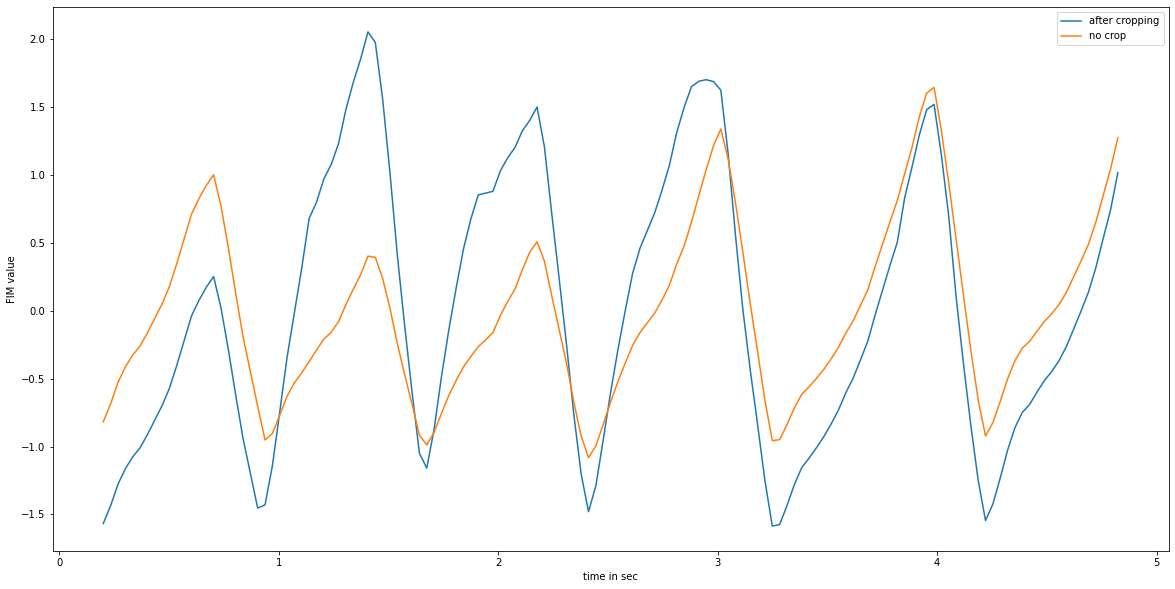

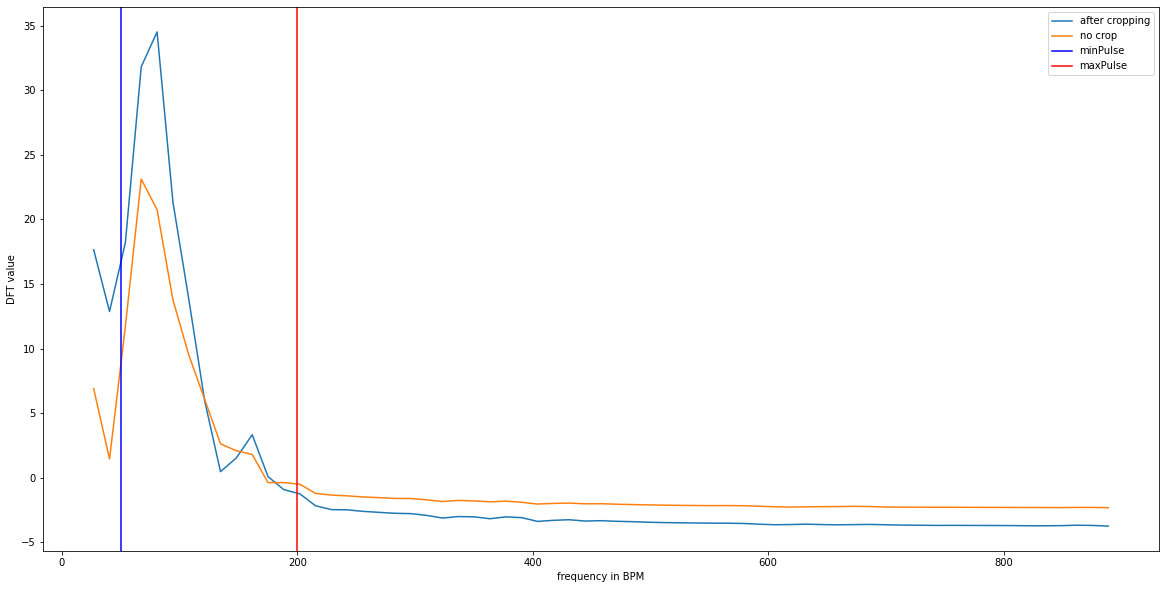

In [60]:
plotClean('EE18B036_1.mp4')

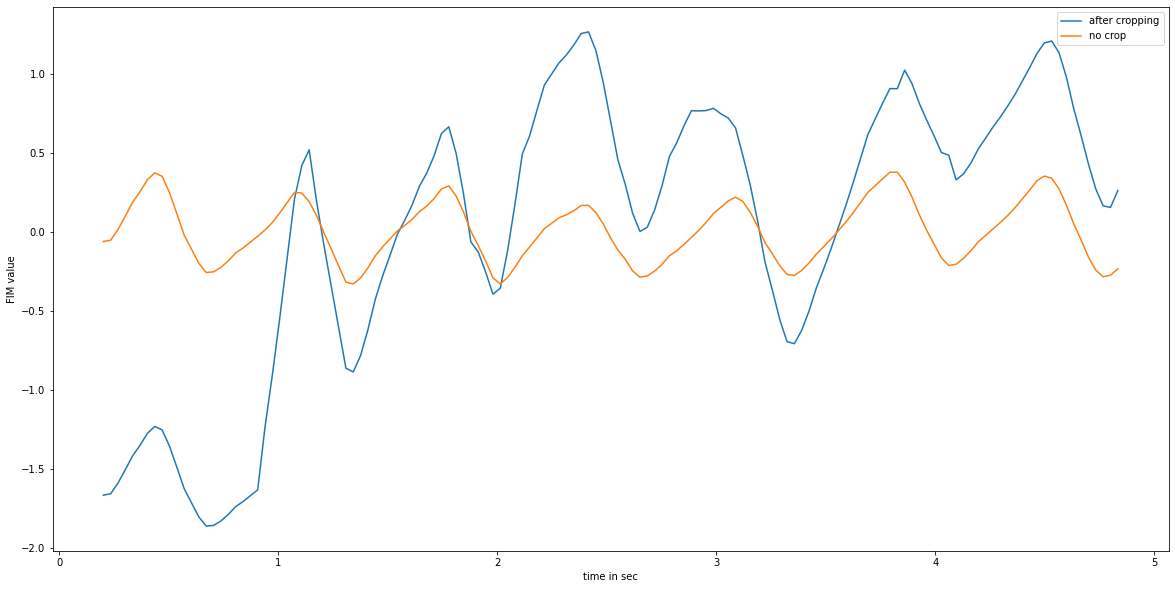

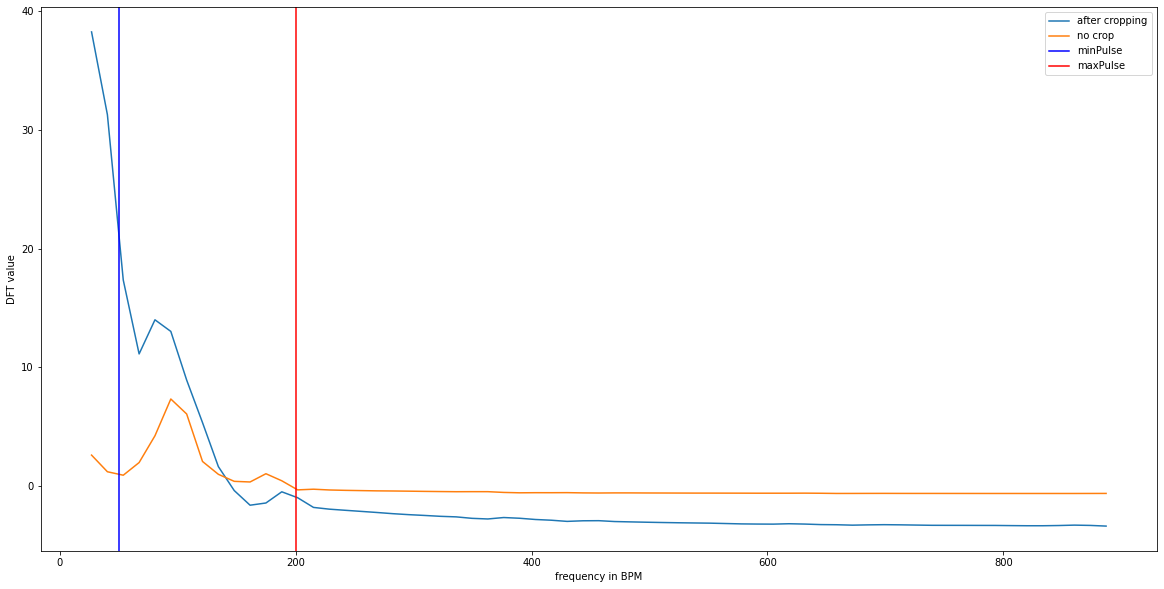

In [61]:
plotClean('EE18B036_2.mp4')

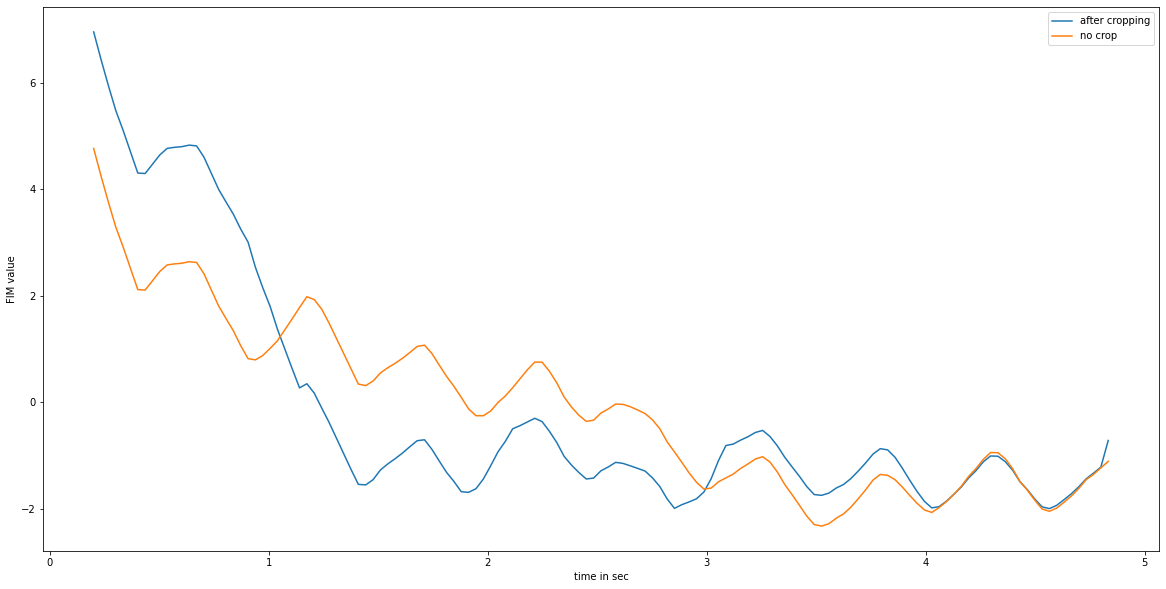

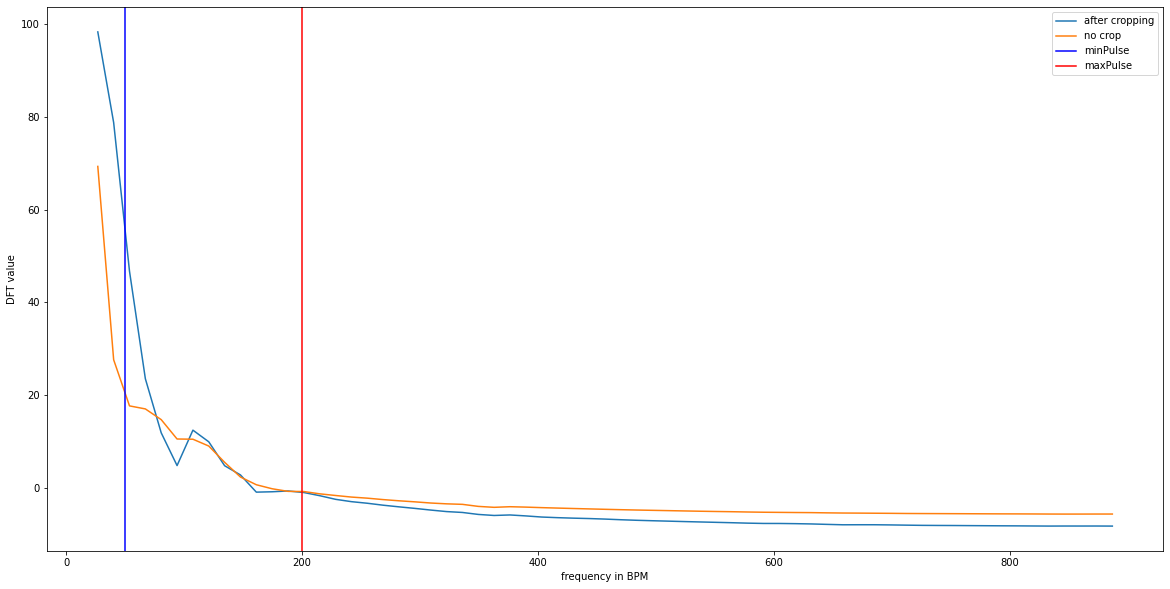

In [62]:
plotClean('EE18B036_3.mp4')